<a href="https://colab.research.google.com/github/WeizmannML/course2019/blob/master/Tutorial9/ImageSegmentation_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make setting for plotting etc. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Extract the relevant packages from fast.ai

In [0]:
import fastai
import numpy as np

### We will use the $fastai.vision$ function through the object $vs$

In [0]:
import fastai.vision as vs

### The $fastai.callbacks.hooks$ will be accessed through $hks$

In [0]:
import  fastai.callbacks.hooks as hks

### We will use the CAMVID dataset in built in fastai

In [5]:
path = vs.untar_data(vs.URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

### Setting the path for images and labels

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

### Get the path to actual images and labels

In [7]:
fnames = vs.get_image_files(path_img)
fnames[:2]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01080.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03120.png')]

In [8]:
lbl_names = vs.get_image_files(path_lbl)
lbl_names[:2]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_07440_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03270_P.png')]

### Let's visualize some input examples 

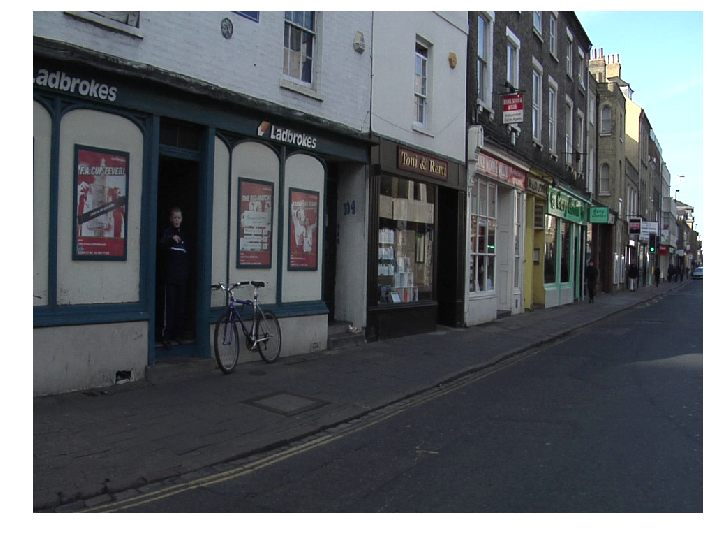

In [9]:
img_f = fnames[6]
img = vs.open_image(img_f)
img.show(figsize=(12,12))

### Q. What's the task ? Ans : $\bf We ~are ~ trying ~ to ~ assign~ labels~ to ~ each ~ pixel ~ in ~ the ~ image.$

Create a function which will return the label (from the label list) for any input image (from the image list)

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [11]:
fnames[6] ## --- test image under use --- #

PosixPath('/root/.fastai/data/camvid/images/0016E5_05790.png')

In [12]:
get_y_fn(fnames[6]) ## ----- the label returned by the get_y_fn ----- ##

PosixPath('/root/.fastai/data/camvid/labels/0016E5_05790_P.png')

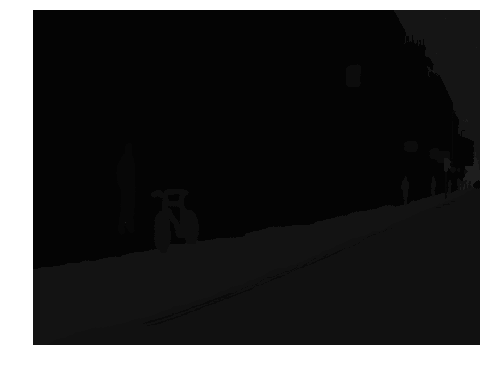

In [13]:
img_label = vs.open_image(get_y_fn(img_f))
img_label.show(figsize=(8,8))

### The $vs.open\_mask$ function assigns integer labels to each pixel in the label-image

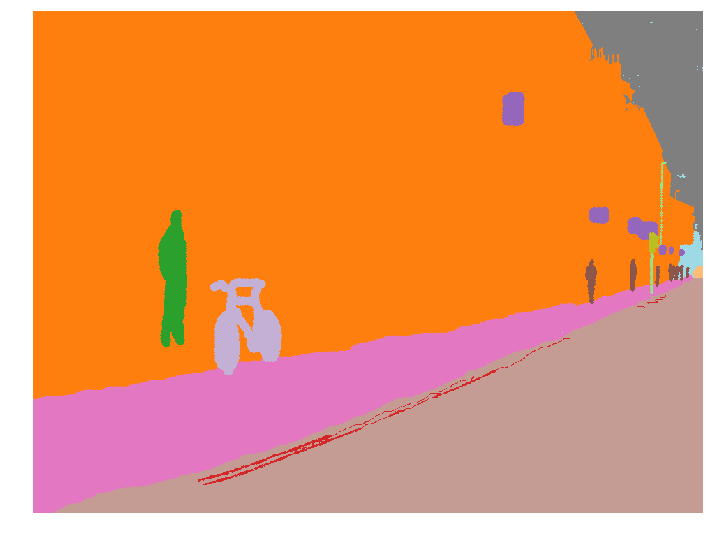

In [14]:
mask = vs.open_mask(get_y_fn(img_f))
mask.show(figsize=(12,12), alpha=1)

In [0]:
# vs.open_mask??
# cat /usr/local/lib/python3.6/dist-packages/fastai/vision/image.py

### How the masked image numerically looks like? Compare it with the original image

In [16]:
type(mask)

fastai.vision.image.ImageSegment

In [17]:
mask.data, mask.shape

(tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]), torch.Size([1, 720, 960]))

In [18]:
img.data, img.shape

(tensor([[[0.4314, 0.4314, 0.4431,  ..., 0.6941, 0.6980, 0.6902],
          [0.4588, 0.4471, 0.4392,  ..., 0.6902, 0.6980, 0.6902],
          [0.4431, 0.4235, 0.4314,  ..., 0.6824, 0.6902, 0.6863],
          ...,
          [0.1098, 0.1137, 0.1255,  ..., 0.1843, 0.1804, 0.1765],
          [0.1647, 0.1686, 0.1765,  ..., 0.1882, 0.1804, 0.1765],
          [0.2118, 0.2118, 0.2235,  ..., 0.1961, 0.1843, 0.1804]],
 
         [[0.4745, 0.4745, 0.4980,  ..., 0.9216, 0.9255, 0.9176],
          [0.5020, 0.4902, 0.4941,  ..., 0.9176, 0.9255, 0.9176],
          [0.4980, 0.4784, 0.4863,  ..., 0.9216, 0.9294, 0.9255],
          ...,
          [0.1137, 0.1176, 0.1294,  ..., 0.2196, 0.2157, 0.2118],
          [0.1686, 0.1725, 0.1804,  ..., 0.2235, 0.2157, 0.2118],
          [0.2157, 0.2157, 0.2275,  ..., 0.2314, 0.2196, 0.2157]],
 
         [[0.5216, 0.5216, 0.5412,  ..., 1.0000, 1.0000, 1.0000],
          [0.5490, 0.5373, 0.5373,  ..., 1.0000, 1.0000, 1.0000],
          [0.5333, 0.5137, 0.5294,  ...,

### Now let's look into the list of pre-defined labels

In [19]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Start creating the data batch

In [0]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs=8

In [0]:
src = (vs.SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
## --- do the pre-processing and normalize to imagenet stats --- ##
data = (src.transform(vs.get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(vs.imagenet_stats))

In [23]:
path.ls()[1]

PosixPath('/root/.fastai/data/camvid/valid.txt')

In [24]:
src ## -- the stats of the labels -- ##

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None

In [25]:
data ## -- the stats of the data -- ##

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None

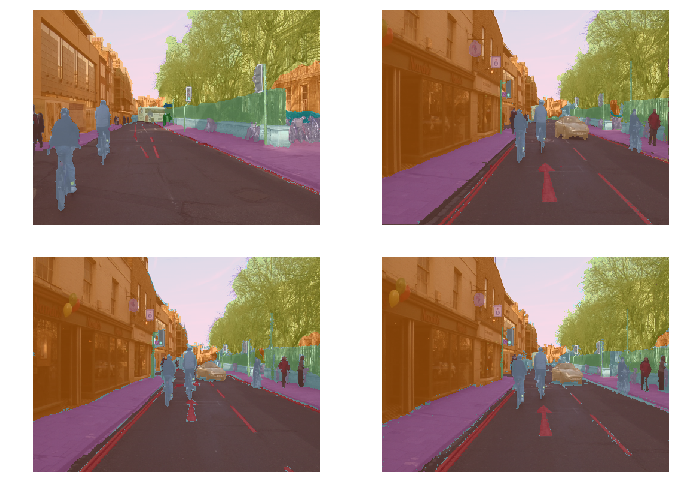

In [26]:
data.show_batch(rows=2, figsize=(10,7), ds_type=vs.DatasetType.Valid)

In [0]:
## --- assign an integer label to each of the classes --- ##
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

## --- designe a customized accuracy function --- #
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [0]:
metrics=acc_camvid
wd=1e-2

### Create the learner from fastai unet_learner

In [30]:
learn = vs.unet_learner(data, vs.models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 105253314.53it/s]


### Run the learning rate finder 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


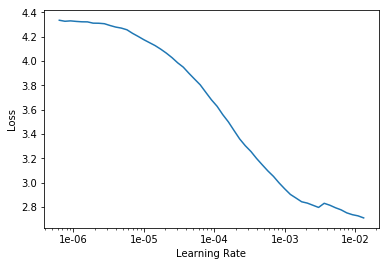

In [31]:
vs.lr_find(learn)
learn.recorder.plot()

### Do the training for 10 epochs and see the output results

In [32]:
learn.fit_one_cycle(10, slice(1e-06,1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.358456,0.871414,0.795826,04:56
1,0.868424,0.615091,0.830869,04:48
2,0.717907,0.664292,0.828900,04:47
3,0.655675,0.491452,0.874421,04:47
4,0.591712,0.461545,0.870255,04:47
5,0.575652,0.530098,0.866611,04:46
6,0.568907,0.457903,0.874718,04:46
7,0.520259,0.375826,0.898552,04:45
8,0.494368,0.389189,0.896571,04:44
9,0.426539,0.321401,0.906779,04:45


In [0]:
path = "."

In [0]:
learn.save('stage-1')

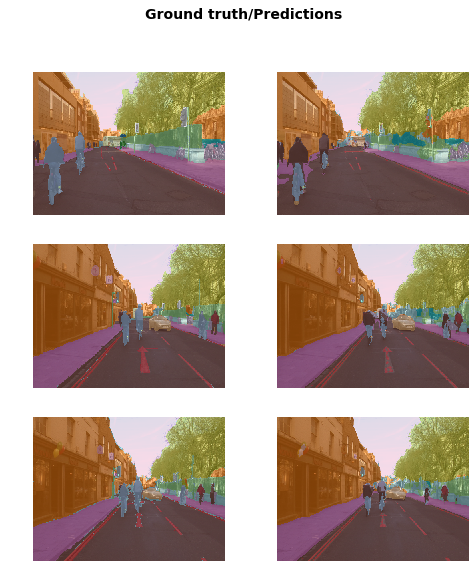

In [35]:
learn.show_results(rows=3, figsize=(8,9))


### Now let all the pre trained weights float 

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


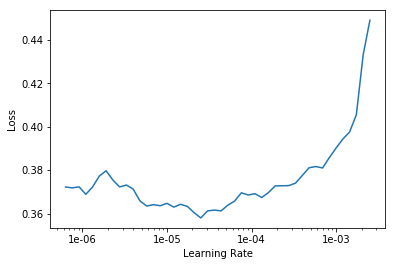

In [37]:
vs.lr_find(learn)
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(20, slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.363604,0.318054,0.906403,04:52
1,0.355240,0.311638,0.909025,04:52
2,0.350704,0.311763,0.909878,04:52


In [0]:
learn.save('stage-2')

In [0]:
learn.show_results(rows=5, figsize=(8,9))